In [16]:
import argparse                 # argument parser
import numpy as np
import nibabel as nib
import SimpleITK as sitk

#### Testing volume functions

In [8]:
def volume( mask_image ):
    # Input:
    # image = sitk.Image, mask or binary image (1 values where organ, 0 values otherwise)
    # Output:
    # vol = float, volume in mm3 
    space = mask_image.GetSpacing()         # image spacing
    voxel = np.prod(space)                  # voxel volume
    img = sitk.GetArrayFromImage(mask_image)
    vol = voxel*np.sum(img)
    return vol

def main():
    # Arguments details
    parser = argparse.ArgumentParser(description='Compute volume of a mask image')
    parser.add_argument("input", type=str, 
                        help='Input file name')

    # Parse arguments
    args = parser.parse_args()
    image_file = args.input

    # Read the image
    try:
        image = sitk.ReadImage(image_file)
    except:
        print('Unable to read input image file.')

    # Calculate the volume
    print('Volume: {:f} [mm3]'.format(volume(image)))
    print('Volume: {:f} [cm3]'.format(volume(image)/1000.0))

    return

In [3]:
def get_volume(binary_img):
    stats = sitk.StatisticsImageFilter()

    # img is a SimpleITK image
    stats.Execute(binary_img)

    # get the number of voxels with label 1
    nvoxels = stats.GetCount(1)

    spacing = binary_img.GetSpacing()
    voxvol = spacing[0]*spacing[1]*spacing[2]

    volume = nvoxels * voxvol

    return volume

In [11]:
path_lesion_mask = '/home/maarhus/Documents/Master/LST_data/LGA/MS_DATA_TEST/1003101869/T1.nii'

sitk_image = sitk.ReadImage(path_lesion_mask, imageIO='NiftiImageIO')

print(volume(sitk_image))

1796367633.0


#### Get volume of binary nifti image

In [17]:
"""Compute volume of non-zero voxels in a nifti image."""

import numpy as np
import nibabel as nb


def get_nifti_volume(image_path):
    # Load data
    nii = nb.load(image_path)
    img = nii.get_fdata()

    # Get voxel dimensions
    voxel_dims = (nii.header["pixdim"])[1:4]
    print("Voxel dimensions:")
    print("  x = {} mm".format(voxel_dims[0]))
    print("  y = {} mm".format(voxel_dims[1]))
    print("  z = {} mm".format(voxel_dims[2]))

    # Compute volume
    nonzero_voxel_count = np.count_nonzero(img)
    voxel_volume = np.prod(voxel_dims)
    nonzero_voxel_volume = nonzero_voxel_count * voxel_volume

    print("Number of non-zero voxels = {}".format(nonzero_voxel_count))
    print("Volume of non-zero voxels = {} mm^3".format(nonzero_voxel_volume))

    return nonzero_voxel_volume


def get_AVE(path_true_mask, path_pred_mask):
    volume_true_mask = get_nifti_volume(path_true_mask)
    volume_pred_mask = get_nifti_volume(path_pred_mask)

    ave = abs(volume_true_mask-volume_pred_mask)

    return ave


In [18]:
INPUT = '/home/maarhus/Documents/Master/LST_data/LGA/MS_DATA_TEST/1003101869/ples_lga_0.2_rmFLAIR.nii'
image_volume = get_nifti_volume(INPUT)
print(image_volume)

Voxel dimensions:
  x = 1.0 mm
  y = 1.0 mm
  z = 1.0 mm
Number of non-zero voxels = 12109
Volume of non-zero voxels = 12109.0 mm^3
12109.0


In [19]:
path_pred = '/home/maarhus/Documents/Master/LST_data/LGA/MS_DATA_TEST/1003101869/thr_0.1_map.nii'
path_true = '/home/maarhus/Documents/Master/LST_data/LGA/MS_DATA_TEST/1003101869/lesions_binarised.nii'

ave = get_AVE(path_true, path_pred)

print(ave)

Voxel dimensions:
  x = 1.0 mm
  y = 1.0 mm
  z = 1.0 mm
Number of non-zero voxels = 6396
Volume of non-zero voxels = 6396.0 mm^3
Voxel dimensions:
  x = 1.0 mm
  y = 1.0 mm
  z = 1.0 mm
Number of non-zero voxels = 6497
Volume of non-zero voxels = 6497.0 mm^3
101.0


In [3]:
def my_dice(img1,img2):
 intersection = np.logical_and(img1, img2)
 union = np.logical_or(img1, img2)
 dice = (2*np.sum(intersection))/(np.sum(union)+np.sum(intersection))
 return dice

pred_image = nib.load(path_pred).get_fdata()
mask_image = nib.load(path_true).get_fdata()

dice_score = my_dice(pred_image, mask_image)

print(dice_score)

0.6181648956798262


#### Get F1 score

In [41]:
from sklearn.metrics import f1_score

y_pred = nib.load(path_pred).get_fdata()

y_true = nib.load(path_true).get_fdata()

print(f1_score(y_true.flatten(), y_pred.flatten()))


0.6181648956798262


#### Sensitivity and Spesificity

In [20]:
def sensitivity (seg,ground): 
    #computs True Positive Rate (TPR)
    num=np.sum(np.multiply(ground, seg ))
    denom=np.sum(ground)
    if denom==0:
        return 1
    else:
        return  num/denom

def specificity (seg,ground): 
    #computes True Negative Rate (TNR)
    num=np.sum(np.multiply(ground==0, seg ==0))
    denom=np.sum(ground==0)
    if denom==0:
        return 1
    else:
        return  num/denom

In [21]:
y_pred = nib.load(path_pred).get_fdata()

y_true = nib.load(path_true).get_fdata()

print(sensitivity(y_pred, y_true))

print(specificity(y_pred, y_true))

0.6230456535334584
0.9997493167084006


In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import colors
import matplotlib.patches as mpatches
import nibabel as nib
#import seaborn as sns

print(len(np.where(y_pred - y_true  == 1)))
print(len(np.where(y_pred - y_true  == 1)[0]))
print(len(np.where(y_pred - y_true  == 1)[1]))
print(len(np.where(y_pred - y_true  == 1)[2]))


FP = len(np.where(y_pred - y_true  == 1)[0])
FN = len(np.where(y_pred - y_true  == -1)[0])
TP = len(np.where(y_pred + y_true ==2)[0])
TN = len(np.where(y_pred + y_true == 0)[0])
cmat = [[TP, FN], [FP, TN]]

tpr = TP/(TP + FN)
tnr = TN/(TN + FP)

print(tpr)
print(tnr)

fpr = FP/(FP + TN)

print(fpr)

3
2512
2512
2512
0.6230456535334584
0.9997493167084006
0.0002506832915993554


In [14]:
def sensitivity(pred_image, true_image):
    TP = len(np.where(pred_image + true_image ==2)[0])
    FN = len(np.where(pred_image - true_image  == -1)[0])
    TPR = TP/(TP + FN)
    return TPR

def specificity(pred_image, true_image):
    TN = len(np.where(pred_image + true_image == 0)[0])
    FP = len(np.where(pred_image - true_image  == 1)[0])
    TNR = TN/(TN + FP)
    return TNR

print(sensitivit(y_pred, y_true))

print(specificit(y_pred, y_true))

0.6230456535334584
0.9997493167084006


/tmp/ipykernel_354517/1687862685.py:43: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  axs.grid(b = True, color ='grey',


Text(0.5, 1.0, 'Dice Score')

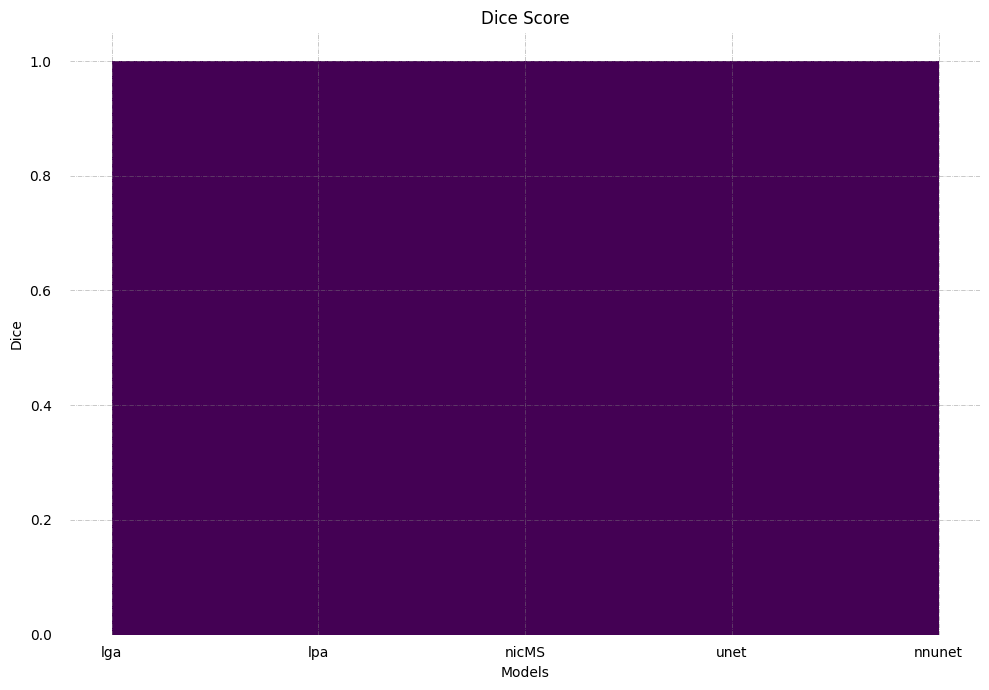

In [101]:
import matplotlib.pyplot as plt

lga = 0.687
lpa = 0.546
nicMS = 0.933
unet = 0.345
nnunet = 0.94

model_list = ('lga', 'lpa', 'nicMS', 'unet', 'nnunet')
score_list = [0.687, 0.546, 0.933, 0.345, 0.94]


import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
 
 
# Creating dataset
np.random.seed(23685752)
n_bins = 5
 
 
# Creating histogram
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
 
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    axs.spines[s].set_visible(False)
 
# Remove x, y ticks
axs.xaxis.set_ticks_position('none')
axs.yaxis.set_ticks_position('none')
   
# Add padding between axes and labels
axs.xaxis.set_tick_params(pad = 5)
axs.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
axs.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)

 
# Creating histogram
N, bins, patches = axs.hist(model_list, bins = n_bins)
 
# Setting color
fracs = ((N**(1 / 5)) / N.max())
norm = colors.Normalize(fracs.min(), fracs.max())
 
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
 
# Adding extra features   
plt.xlabel("Models")
plt.ylabel("Dice")
plt.title('Dice Score')
 
# Show plot
#plt.show()

/tmp/ipykernel_4940/1339643256.py:30: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  axs.grid(b = True, color ='gray',


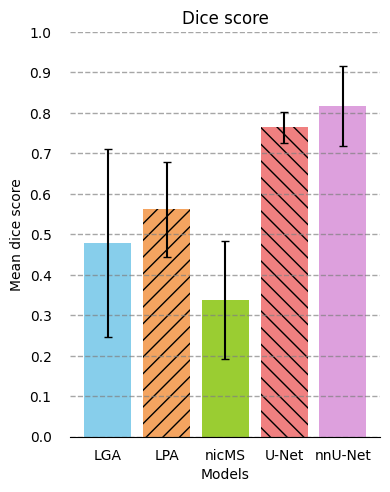

In [124]:
model_list = ('LGA', 'LPA', 'nicMS', 'U-Net', 'nnU-Net')
score_list = [0.479, 0.562, 0.337, 0.764, 0.817]
error = [0.232, 0.117, 0.146, 0.039, 0.098]

x_pos = np.arange(len(model_list))

# Creating histogram
fig, axs = plt.subplots(1, 1,
                        figsize =(4, 5),
                        tight_layout = True)
 
 
# Remove axes splines
for s in ['top', 'left', 'right']:
    axs.spines[s].set_visible(False)
 
# Remove x, y ticks
axs.xaxis.set_ticks_position('none')
axs.yaxis.set_ticks_position('none')

#axs.set_yticks(range(0,1,0.1))
   
# Add padding between axes and labels
axs.xaxis.set_tick_params(pad = 5)
axs.yaxis.set_tick_params(pad = 10)

plt.ylim(0, 0.9)
 
# Add x, y gridlines
axs.grid(b = True, color ='gray',
        linestyle ='--', linewidth = 1,
        alpha = 0.7, axis='y')
 
farger1 = ["skyblue", "sandybrown", "yellowgreen", "lightcoral", "plum"]
farger2 = ['royalblue', 'orange', 'limegreen', 'crimson', 'mediumpurple']
hatch1 = ["", "//", "", "\\\\", ""]
plt.bar(x_pos, score_list, yerr=error, color=farger1, capsize=3, hatch =  hatch1)

plt.xticks(x_pos, model_list)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

plt.xlabel("Models")
plt.ylabel("Mean dice score")
plt.title("Dice score")
#plt.savefig('/home/maarhus/Documents/Master/python_code/code/Figures/meanDSC_barplot_test.eps', format='eps', bbox_inches='tight')
plt.savefig('/home/maarhus/Documents/Master/python_code/code/Figures/meanDSC_barplot.png', format='png', bbox_inches='tight', dpi =600)
plt.show()

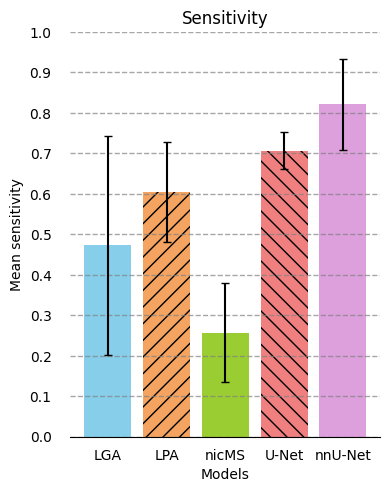

In [126]:
model_list = ('LGA', 'LPA', 'nicMS', 'U-Net', 'nnU-Net')
score_list = [0.473, 0.605, 0.257, 0.707, 0.821]
error = [0.271, 0.123, 0.123, 0.046, 0.113]

x_pos = np.arange(len(model_list))

# Creating histogram
fig, axs = plt.subplots(1, 1,
                        figsize =(4, 5),
                        tight_layout = True)
 
 
# Remove axes splines
for s in ['top', 'left', 'right']:
    axs.spines[s].set_visible(False)
 
# Remove x, y ticks
axs.xaxis.set_ticks_position('none')
axs.yaxis.set_ticks_position('none')

#axs.set_yticks(range(0,1,0.1))
   
# Add padding between axes and labels
axs.xaxis.set_tick_params(pad = 5)
axs.yaxis.set_tick_params(pad = 10)

plt.ylim(0, 1)
 
# Add x, y gridlines
axs.grid(visible = True, color ='gray',
        linestyle ='--', linewidth = 1,
        alpha = 0.7, axis='y')

hatch1 = ["", "//", "", "\\\\", ""]
farger1 = ["skyblue", "sandybrown", "yellowgreen", "lightcoral", "plum"]
plt.bar(x_pos, score_list, yerr=error, color=farger1, hatch = hatch1, capsize=3)

plt.xticks(x_pos, model_list)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

plt.xlabel("Models")
plt.ylabel("Mean sensitivity")
plt.title("Sensitivity")

#plt.savefig('/home/maarhus/Documents/Master/python_code/code/Figures/meanSensitivity_barplot.eps', format='eps', bbox_inches='tight')
plt.savefig('/home/maarhus/Documents/Master/python_code/code/Figures/meanSensitivity_barplot.png', format='png', bbox_inches='tight', dpi =600)

plt.show()


/tmp/ipykernel_4940/1834466408.py:30: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  axs.grid(b = True, color ='gray',


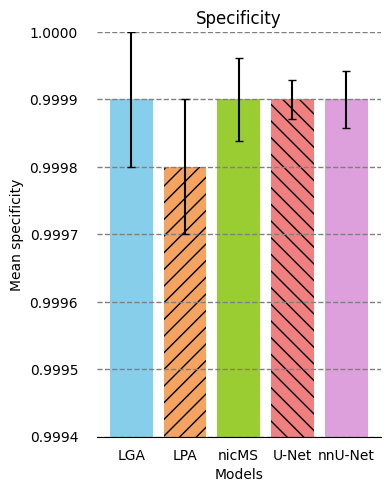

In [127]:
model_list = ('LGA', 'LPA', 'nicMS', 'U-Net', 'nnU-Net')
score_list = [0.9999, 0.9998, 0.9999, 0.9999, 0.9999]
error = [0.0001, 0.0001, 6.120509582749089e-05, 2.9413868397480577e-05, 4.214549887263986e-05]

x_pos = np.arange(len(model_list))

# Creating histogram
fig, axs = plt.subplots(1, 1,
                        figsize =(4, 5),
                        tight_layout = True)
 
 
# Remove axes splines
for s in ['top', 'left', 'right']:
    axs.spines[s].set_visible(False)
 
# Remove x, y ticks
axs.xaxis.set_ticks_position('none')
axs.yaxis.set_ticks_position('none')

#axs.set_yticks(range(0,1,0.1))
   
# Add padding between axes and labels
axs.xaxis.set_tick_params(pad = 5)
axs.yaxis.set_tick_params(pad = 10)


 
# Add x, y gridlines
axs.grid(b = True, color ='gray',
        linestyle ='--', linewidth = 1,
        alpha = 1, axis='y')

hatch1 = ["", "//", "", "\\\\", ""]
farger1 = ["skyblue", "sandybrown", "yellowgreen", "lightcoral", "plum"]
plt.bar(x_pos, score_list, yerr=error, color=farger1, hatch = hatch1, capsize=3)


plt.xticks(x_pos, model_list)
plt.yticks([0.9990, 0.9991, 0.9992, 0.9993, 0.9994, 0.9995, 0.9996, 0.9997, 0.9998, 0.9999, 1])

plt.xlabel("Models")
plt.ylabel("Mean specificity")
plt.title("Specificity")

plt.ylim(0.9994, 1)
#plt.savefig('/home/maarhus/Documents/Master/python_code/code/Figures/meanSpecificity_barplot.eps', format='eps')
plt.savefig('/home/maarhus/Documents/Master/python_code/code/Figures/meanSpecificity_barplot.png', format='png', bbox_inches='tight', dpi =600)
plt.show()

#### Spider plot

In [6]:
import plotly.express as px
import pandas as pd
df = pd.DataFrame(dict(
    r=[10, 25, 29, 30, 17],
    theta=['lga', 'lpa', 'nicMS', 'unet', 'nnunet']))
fig = px.line_polar(df, r='r', theta='theta', line_close=True)
fig.update_traces(fill='toself')
fig.show()

model_list = ('lga', 'lpa', 'nicMS', 'unet', 'nnunet')
score_list = [0.687, 0.546, 0.933, 0.345, 0.94]

/home/maarhus/.local/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



#### Graphs of small lesions

In [5]:
assert 0.223 == round(0.22268272873217804, 3)
print("ok")

ok


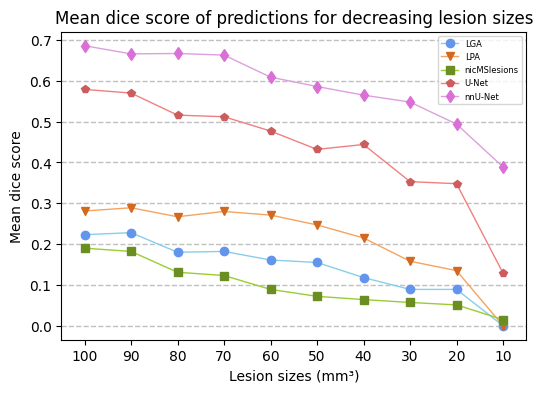

In [140]:
# importing package
import matplotlib.pyplot as plt
import numpy as np

# create data
gjennomsnitt_lga = [0.223, 0.228, 0.18, 0.182, 0.161, 0.155, 0.118, 0.089, 0.089, 0.0]
error_lga = [0.152, 0.147, 0.168, 0.162, 0.141, 0.135, 0.119, 0.12, 0.104, 0.0]
participant_1389542280_lga = [0.405, 0.405, 0.372, 0.372, 0.242, 0.171, 0.09, 0.045, 0.073, 0.0]

gjennomsnitt_lpa = [0.281, 0.289, 0.267, 0.28, 0.271, 0.247, 0.215, 0.158, 0.135, 0.0]
error_lpa = [0.144, 0.139, 0.148, 0.134, 0.145, 0.097, 0.075, 0.112, 0.126, 0.0]
participant_1389542280_lpa = [0.516, 0.516, 0.452, 0.452, 0.468, 0.343, 0.253, 0.172, 0.156, 0.0]

gjennomsnitt_nicms = [0.19, 0.182, 0.131, 0.123, 0.089, 0.072, 0.064, 0.057, 0.051, 0.015]
error_nicms = [0.136, 0.126, 0.114, 0.086, 0.082, 0.082, 0.071, 0.084, 0.082, 0.032]
participant_1389542280_nicms = [0.257, 0.257, 0.16, 0.16, 0.179, 0.075, 0.097, 0.11, 0.049, 0.0]

gjennomsnitt_nnunet = [0.686, 0.666, 0.667, 0.663, 0.609, 0.586, 0.565, 0.548, 0.494, 0.389]
error_nnunet = [0.127, 0.154, 0.142, 0.153, 0.188, 0.2, 0.198, 0.204, 0.23, 0.153]
participant_1389542280_nnunet = [0.859, 0.859, 0.815, 0.815, 0.78, 0.74, 0.7, 0.742, 0.676, 0.526]

gjennomsnitt_fast = [0.579, 0.57, 0.516, 0.512, 0.477, 0.432, 0.444, 0.353, 0.348, 0.129]
error_fast = [0.084, 0.109, 0.153, 0.125, 0.123, 0.169, 0.158, 0.155, 0.144, 0.116]
participant_1389542280_fast = [0.615, 0.615, 0.623, 0.623, 0.555, 0.517, 0.467, 0.414, 0.476, 0.13]

y = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
x = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]


# plot lines
#ax = plt.subplot(111)

#for s in ['top', 'left', 'right', 'bottom']:
    #ax.spines[s].set_visible(False)

plt.grid(visible = True, color ='silver',
        linestyle ='--', linewidth = 1,
        alpha = 1, axis='y')

farger1 = ["skyblue", "sandybrown", "yellowgreen", "lightcoral", "plum"]

plt.plot(x, gjennomsnitt_lga, label = "LGA", linestyle="-", marker="o", color = "skyblue", mfc = "cornflowerblue", mec = "cornflowerblue", linewidth = 1)
#plt.errorbar(x, gjennomsnitt_lga, yerr=error_lga, capsize=5)
plt.plot(x, gjennomsnitt_lpa, label = "LPA", linestyle="-", marker="v", color = "sandybrown",  mfc = "chocolate", mec = "chocolate", linewidth = 1)
plt.plot(x, gjennomsnitt_nicms, label = "nicMSlesions", linestyle="-", marker="s", color = "yellowgreen",mfc = "olivedrab", mec = "olivedrab", linewidth = 1)
plt.plot(x, gjennomsnitt_fast, label = "U-Net", linestyle ="-", marker="p", color = "lightcoral", mfc = "indianred", mec = "indianred", linewidth = 1)
plt.plot(x, gjennomsnitt_nnunet, label = "nnU-Net", linestyle="-", marker="d", color = "plum", mfc = "orchid", mec = "orchid", linewidth = 1)
plt.xlim(max(x)+5, min(x)-5)
plt.xticks(x)
plt.legend( loc = "upper right", prop={'size': 6})
plt.gcf().set_size_inches(6, 4)
plt.xlabel("Lesion sizes (mm\u00b3)")
plt.ylabel("Mean dice score")
plt.title("Mean dice score of predictions for decreasing lesion sizes")
#plt.savefig('/home/maarhus/Documents/Master/python_code/code/Figures/meanDSC_small_lesions.eps', format='eps', bbox_inches='tight')
plt.savefig('/home/maarhus/Documents/Master/python_code/code/Figures/meanDSC_small_lesions.png', format='png', bbox_inches='tight', dpi =600)
plt.show()



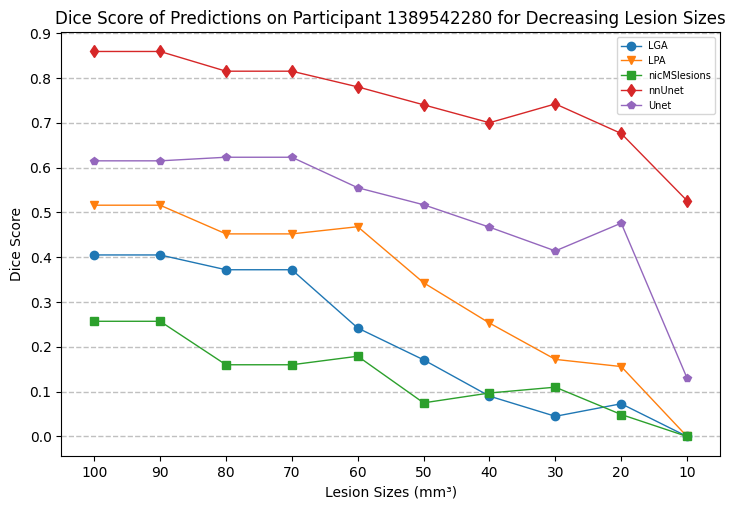

In [18]:
# importing package
import matplotlib.pyplot as plt

# create data
gjennomsnitt_lga = [0.223, 0.228, 0.18, 0.182, 0.161, 0.155, 0.118, 0.089, 0.089, 0.0]
error_lga = [0.152, 0.147, 0.168, 0.162, 0.141, 0.135, 0.119, 0.12, 0.104, 0.0]
participant_1389542280_lga = [0.405, 0.405, 0.372, 0.372, 0.242, 0.171, 0.09, 0.045, 0.073, 0.0]

gjennomsnitt_lpa = [0.281, 0.289, 0.267, 0.28, 0.271, 0.247, 0.215, 0.158, 0.135, 0.0]
error_lpa = [0.144, 0.139, 0.148, 0.134, 0.145, 0.097, 0.075, 0.112, 0.126, 0.0]
participant_1389542280_lpa = [0.516, 0.516, 0.452, 0.452, 0.468, 0.343, 0.253, 0.172, 0.156, 0.0]

gjennomsnitt_nicms = [0.19, 0.182, 0.131, 0.123, 0.089, 0.072, 0.064, 0.057, 0.051, 0.015]
error_nicms = [0.136, 0.126, 0.114, 0.086, 0.082, 0.082, 0.071, 0.084, 0.082, 0.032]
participant_1389542280_nicms = [0.257, 0.257, 0.16, 0.16, 0.179, 0.075, 0.097, 0.11, 0.049, 0.0]

gjennomsnitt_nnunet = [0.686, 0.666, 0.667, 0.663, 0.609, 0.586, 0.565, 0.548, 0.494, 0.389]
error_nnunet = [0.127, 0.154, 0.142, 0.153, 0.188, 0.2, 0.198, 0.204, 0.23, 0.153]
participant_1389542280_nnunet = [0.859, 0.859, 0.815, 0.815, 0.78, 0.74, 0.7, 0.742, 0.676, 0.526]

gjennomsnitt_fast = [0.579, 0.57, 0.516, 0.512, 0.477, 0.432, 0.444, 0.353, 0.348, 0.129]
error_fast = [0.084, 0.109, 0.153, 0.125, 0.123, 0.169, 0.158, 0.155, 0.144, 0.116]
participant_1389542280_fast = [0.615, 0.615, 0.623, 0.623, 0.555, 0.517, 0.467, 0.414, 0.476, 0.13]

y = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
x = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]

  
# plot lines
#ax = plt.subplot(111)

#for s in ['top', 'left', 'right', 'bottom']:
    #ax.spines[s].set_visible(False)

plt.grid(visible = True, color ='silver',
        linestyle ='--', linewidth = 1,
        alpha = 1, axis='y')

y = np.arange(0, 1, 0.1)

plt.plot(x, participant_1389542280_lga, label = "LGA", linestyle="-", marker="o", linewidth = 1)
#plt.errorbar(x, gjennomsnitt_lga, yerr=error_lga, capsize=5)
plt.plot(x, participant_1389542280_lpa, label = "LPA", linestyle="-", marker="v", linewidth = 1)
plt.plot(x, participant_1389542280_nicms, label = "nicMSlesions", linestyle="-", marker="s", linewidth = 1)
plt.plot(x, participant_1389542280_fast, label = "Unet", linestyle ="-", marker="p", linewidth = 1)
plt.plot(x, participant_1389542280_nnunet, label = "nnUnet", linestyle="-", marker="d", linewidth = 1)
plt.xlim(max(x)+5, min(x)-5)
#plt.ylim(max(y)+5, min(y)-5)
plt.yticks(y)
plt.xticks(x)
plt.legend( loc = "upper right", prop={'size': 7})
plt.gcf().set_size_inches(8.5, 5.5)
plt.xlabel("Lesion Sizes (mm\u00b3)")
plt.ylabel("Dice Score")
#plt.savefig('/home/maarhus/Documents/Master/python_code/code/Figures/meanDSC_small_lesions.eps', format='eps', bbox_inches='tight')
plt.title("Dice Score of Predictions on Participant 1389542280 for Decreasing Lesion Sizes")
plt.show()

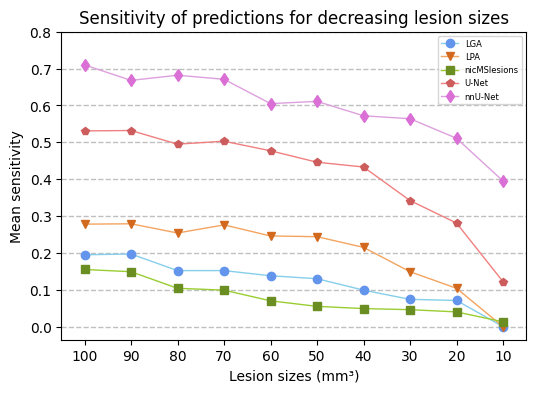

In [138]:
# importing package
import matplotlib.pyplot as plt

# create data

sens_lga = [0.195, 0.197, 0.152, 0.152, 0.138, 0.13, 0.099, 0.074, 0.071, 0.0]
error_lga = [0.131, 0.125, 0.142, 0.137, 0.12, 0.11, 0.09, 0.093, 0.078, 0.0]

sens_lpa = [0.278, 0.279, 0.254, 0.276, 0.246, 0.244, 0.215, 0.149, 0.104, 0.0]
error_lpa = [0.143, 0.134, 0.129, 0.115, 0.126, 0.083, 0.063, 0.104, 0.095, 0.0]

sens_nicms = [0.155, 0.149, 0.104, 0.099, 0.07, 0.055, 0.049, 0.046, 0.04, 0.013]
error_nicms = [0.107, 0.1, 0.085, 0.07, 0.065, 0.062, 0.054, 0.065, 0.064, 0.028]

sens_nnunet = [0.71, 0.668, 0.682, 0.671, 0.605, 0.611, 0.572, 0.564, 0.511, 0.395]
error_nnunet = [0.143, 0.157, 0.156, 0.184, 0.23, 0.253, 0.24, 0.223, 0.275, 0.176]

sens_fm = [0.531, 0.532, 0.495, 0.503, 0.477, 0.446, 0.433, 0.342, 0.281, 0.122]
error_fm =[0.078, 0.087, 0.135, 0.106, 0.098, 0.174, 0.162, 0.158, 0.125, 0.109]

y = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
x = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]

  
# plot lines
#ax = plt.subplot(111)

#for s in ['top', 'left', 'right', 'bottom']:
    #ax.spines[s].set_visible(False)

plt.grid(visible = True, color ='silver',
        linestyle ='--', linewidth = 1,
        alpha = 1, axis='y')

y = np.arange(0, 0.9, 0.1)

plt.plot(x, sens_lga, label = "LGA", linestyle="-", marker="o", color = "skyblue", mfc = "cornflowerblue", mec = "cornflowerblue", linewidth = 1)
#plt.errorbar(x, gjennomsnitt_lga, yerr=error_lga, capsize=5)
plt.plot(x, sens_lpa, label = "LPA", linestyle="-", marker="v", color = "sandybrown",  mfc = "chocolate", mec = "chocolate", linewidth = 1)
plt.plot(x, sens_nicms, label = "nicMSlesions", linestyle="-", marker="s", color = "yellowgreen",mfc = "olivedrab", mec = "olivedrab", linewidth = 1)
plt.plot(x, sens_fm, label = "U-Net", linestyle ="-", marker="p", color = "lightcoral", mfc = "indianred", mec = "indianred", linewidth = 1)
plt.plot(x, sens_nnunet, label = "nnU-Net", linestyle="-", marker="d", color = "plum", mfc = "orchid", mec = "orchid", linewidth = 1)
plt.xlim(max(x)+5, min(x)-5)
#plt.ylim(max(y)+5, min(y)-5)
plt.yticks(y)
plt.xticks(x)
plt.legend( loc = "upper right", prop={'size': 6})
plt.gcf().set_size_inches(6, 4)
plt.xlabel("Lesion sizes (mm\u00b3)")
plt.ylabel("Mean sensitivity")
plt.title("Sensitivity of predictions for decreasing lesion sizes")
#plt.savefig('/home/maarhus/Documents/Master/python_code/code/Figures/meanSensitivty_small_lesions.eps', format='eps', bbox_inches='tight')
plt.savefig('/home/maarhus/Documents/Master/python_code/code/Figures/meanSensitivity_small_lesions.png', format='png', bbox_inches='tight', dpi =600)
plt.show()

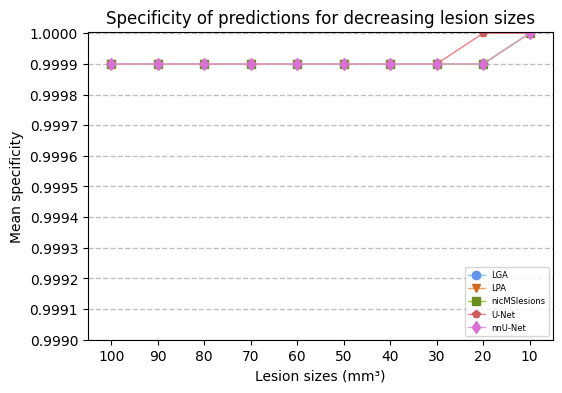

In [139]:
# importing package
import matplotlib.pyplot as plt

# create data

spec_lga = [0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 1.0]
error_lga = [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 0.0, 0.0]

spec_lpa = [0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 1.0]
error_lpa = [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 0.0, 0.0, 0.0]

spec_nicms = [0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 1.0]
error_nicms = [2e-05, 2e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 0.0, 0.0]

spec_nnunet = [0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 1.0]
error_nnunet = [2e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 0.0, 0.0, 0.0]

spec_fm = [0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 1.0, 1.0]
error_spec = [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 0.0, 0.0, 0.0, 0.0]

y = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
x = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]

  
# plot lines
#ax = plt.subplot(111)

#for s in ['top', 'left', 'right', 'bottom']:
    #ax.spines[s].set_visible(False)

plt.grid(visible = True, color ='silver',
        linestyle ='--', linewidth = 1,
        alpha = 1, axis='y')

y = np.arange(0.9990, 1., 0.0001)

plt.plot(x, spec_lga, label = "LGA", linestyle="-", marker="o", color = "skyblue", mfc = "cornflowerblue", mec = "cornflowerblue", linewidth = 1)
#plt.errorbar(x, gjennomsnitt_lga, yerr=error_lga, capsize=5)
plt.plot(x, spec_lpa, label = "LPA", linestyle="-", marker="v", color = "sandybrown",  mfc = "chocolate", mec = "chocolate", linewidth = 1)
plt.plot(x, spec_nicms, label = "nicMSlesions", linestyle="-", marker="s", color = "yellowgreen",mfc = "olivedrab", mec = "olivedrab", linewidth = 1)
plt.plot(x, spec_fm, label = "U-Net", linestyle ="-", marker="p", color = "lightcoral", mfc = "indianred", mec = "indianred", linewidth = 1)
plt.plot(x, spec_nnunet, label = "nnU-Net", linestyle="-", marker="d", color = "plum", mfc = "orchid", mec = "orchid", linewidth = 1)
plt.xlim(max(x)+5, min(x)-5)
#plt.ylim(max(y)+5, min(y)-5)
plt.yticks(y)
plt.xticks(x)
plt.legend( loc = "lower right", prop={'size': 6})
plt.gcf().set_size_inches(6, 4)
plt.xlabel("Lesion sizes (mm\u00b3)")
plt.ylabel("Mean specificity")
plt.title("Specificity of predictions for decreasing lesion sizes")
#plt.savefig('/home/maarhus/Documents/Master/python_code/code/Figures/meanSpecificty_small_lesions.eps', format='eps', bbox_inches='tight')
plt.savefig('/home/maarhus/Documents/Master/python_code/code/Figures/meanSpecificty_small_lesions.png', format='png', bbox_inches='tight', dpi =600)
plt.show()